In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

%matplotlib inline

import os

In [2]:
DATA_ROOT = 'Data'
DB_NAME = 'amiunique-1month-aug17.sqlite3'

PATH_TO_DB = os.path.join(DATA_ROOT, DB_NAME)

In [3]:
con = sqlite3.connect(PATH_TO_DB)
df = pd.read_sql_query('select * from fpData', con)

In [4]:
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn import preprocessing

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn import cross_validation as cv
from sklearn.model_selection import train_test_split

/Users/joel/.virtualenvs/ds_generic/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
#fingerprint_target = df.userAgentHttp
#fingerprint_data = df.drop('userAgentHttp', axis=1)

%time X = pd.get_dummies(df)

#fingerprint_data = fingerprint.drop('userAgentHttp', axis=1)
#fingerprint_target = fingerprint.userAgentHttp

CPU times: user 12.4 s, sys: 1.51 s, total: 13.9 s
Wall time: 14.1 s


In [6]:
# Code From: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

X_samp = X.sample(n=100)

# generate the linkage matrix
Z = linkage(X_samp, 'ward')

In [7]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X_samp))
c

0.76705068371615204

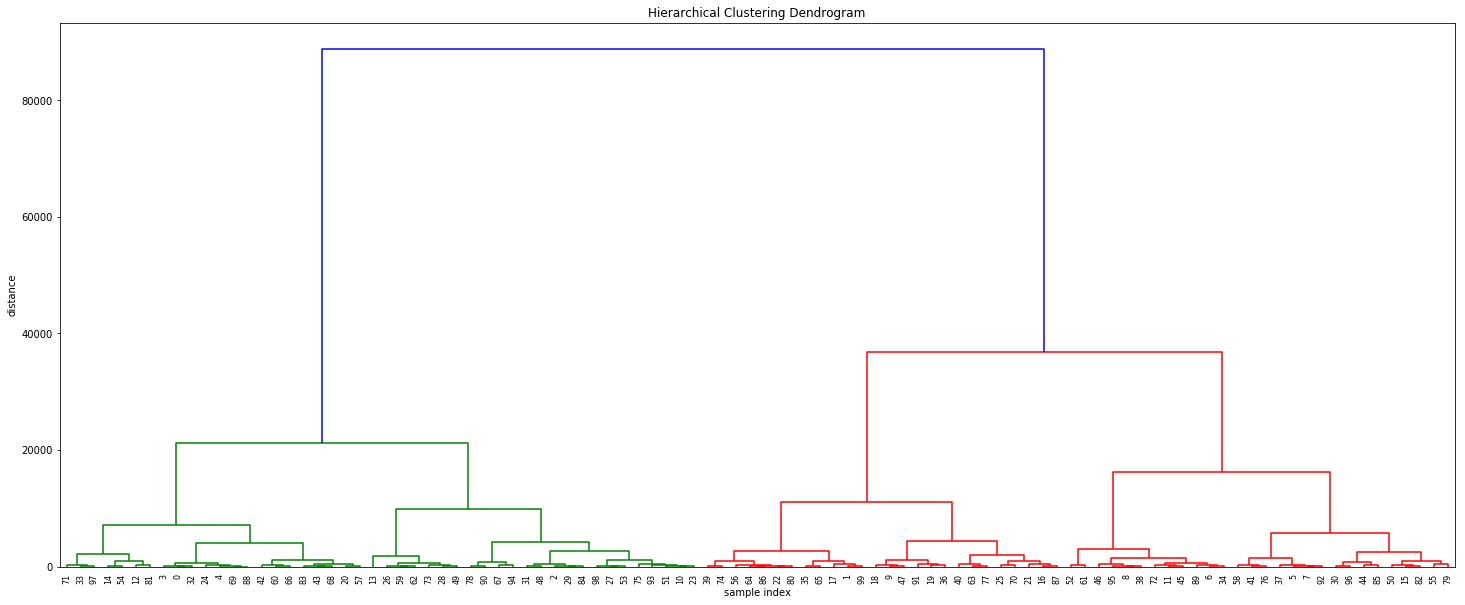

In [9]:

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()